# Modularbeit Neuronale Netze für betriebswirtschafltiche Anwendungen

von Nicholas Aiken (40214918) und Christian Kallmaier (39573418)

## Aufbau

1. Vorbereitungen
2. Vergleich mehererer neuronaler Netze für die Klassifikation von Graustufen-Bildern
    1. Standard Multi-Layer Perzeptron
        1. mit 3 Schichten (ein Hidden-Layer)
            1. Dropout vs. kein Dropout
            2. Vergleich mehrerer Aktivierungsfunktionen
            3. Vergleich mehrerer Fehlerfunktionen
            4. Vergleich mehererer Optimizer
            5. Variation von Batchsize und Epochs
        2. tiefes Netz mit mehreren Hidden-Layers
            1. Dropout vs. kein Dropout
            2. Vergleich mehrerer Aktivierungsfunktionen
            3. Vergleich mehrerer Fehlerfunktionen
            4. Vergleich mehererer Optimizer
            5. Variation von Batchsize und Epochs
    2. Convolutional Neuronal Network
        1. Variation verschiedener Convolution-Layer
        2. Dropout vs. kein Dropout
        3. Vergleich mehrerer Aktivierungsfunktionen
        4. Vergleich mehrerer Fehlerfunktionen
        5. Vergleich mehererer Optimizer
        6. Variation von Batchsize und Epochs
    3. Convolutional Neuronal Network mit Autoencoder
3. Anwendung der Ergebnisse auf die Klassifikation von RGB-Farbbildern
    1. MLP
    2. CNN

## 1. Vorbereitungen

Zunächst müssen alle notwendigen Pakete und Bibliotheken importiert werden:

In [65]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#den oberen Teil kennt man schon vom letzten Mal...
#Theano kommt neu dazu - 
#Library für effiziente Berechnungen mit großen Matrizen -> DeepLearning!
import theano 
import tensorflow

 
#Jetzt noch scikit-learn:
#hier stecken viele Funktionalitäten drin, die man gut brauchen kann: 
#Fehlerfunktionen, Standard-Modelltypen, Preprocessing-Algorithmen, Daten... 

import sklearn as sl 
from sklearn import model_selection, metrics, datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
#Import wichtiger Keras Funktionalitäten

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras.utils import to_categorical
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import plot_model

import pickle

Anschließend werden die notwendigen Daten als .pickle Files geladen und soweit notwendig vorverarbeitet.
Im Rahmen dieser Arbeit nutzen wir die Datensätze data1.pickle und data6.pickle.

data1.pickle enthält die vorverarbeiteten Daten zur Klassifikation deutscher Verkehrsschilder in Farbe, data6.pickle enthält die Daten in Graustufen. Alle Daten sind bereits mit dem Faktor 255 auf einen Bereich zwischen 0 und 1 normalisiert. 

In [31]:

# prepare gray scale data
data_gray_file = open('./archive/data6.pickle', 'rb')
data_gray = pickle.load(data_gray_file, encoding='latin1')
data_gray_file.close()

# Preparing y_train and y_validation for use in Keras
data_gray['y_train'] = to_categorical(data_gray['y_train'], num_classes=43)
data_gray['y_validation'] = to_categorical(data_gray['y_validation'], num_classes=43)


# prepare color data
data_color_file = open('./archive/data1.pickle', 'rb')
data_color = pickle.load(data_color_file, encoding='latin1')
data_color_file.close()

# Preparing y_train and y_validation for use in Keras
data_color['y_train'] = to_categorical(data_color['y_train'], num_classes=43)
data_color['y_validation'] = to_categorical(data_color['y_validation'], num_classes=43)


### Shape der Daten

Um einen Überblick über die Datensätze zu bekommen, geben wir die Shape der einzelnen Datensätze an und plotten Beispiele der enthaltenen Bilder:

##### Graustufen:

In [58]:
# Showing shapes of loaded data
for i, j in data_gray.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

y_train: (86989, 43)
y_validation: (4410, 43)
y_test: (12630,)
labels: 43
x_train: (86989, 1, 32, 32)
x_validation: (4410, 1, 32, 32)
x_test: (12630, 1, 32, 32)


##### Farbe

In [59]:
# Showing shapes of loaded data
for i, j in data_color.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

x_train: (86989, 3, 32, 32)
y_test: (12630,)
x_test: (12630, 3, 32, 32)
x_validation: (4410, 3, 32, 32)
labels: 43
y_train: (86989, 43)
y_validation: (4410, 43)


Um die Daten sinnvoll verarbeiten zu können, verschieben wir die Grau-/Farb-Kanäle ans Ende der Vektoren und führen One-Hot-Encoding für die Labels aus:

In [34]:
# Transpose data to have channel at the end
x_train_gray = data_gray['x_train'].transpose(0, 2, 3, 1)
x_train_color = data_color['x_train'].transpose(0, 2, 3, 1)

x_test_gray = data_gray['x_test'].transpose(0, 2, 3, 1)
x_test_color = data_color['x_test'].transpose(0, 2, 3, 1)

# one hot encoding
y_test_gray = to_categorical(data_gray['y_test'], num_classes=43)
y_test_color = to_categorical(data_color['y_test'], num_classes=43)

print('x_train_gray.shape: ' + str(x_train_gray.shape))
print('x_train_color.shape: ' + str(x_train_color.shape))
print('x_test_gray.shape: ' + str(x_test_gray.shape))
print('x_test_color.shape: ' + str(x_test_color.shape))
print('y_test_gray.shape: ' + str(y_test_gray.shape))
print('y_test_color.shape: ' + str(y_test_color.shape))

x_train_gray.shape: (86989, 32, 32, 1)
x_train_color.shape: (86989, 32, 32, 3)
x_test_gray.shape: (12630, 32, 32, 1)
x_test_color.shape: (12630, 32, 32, 3)
y_test_gray.shape: (12630, 43)
y_test_color.shape: (12630, 43)


### Utilities

Für mehr Komfort werden im Folgenden einige Funktionen definiert, die die Arbeit mit Daten, Plots und Modellen erleichtern.

##### Confusion Matrix

In [ ]:
def plotConfusionMatrix(y_true, y_pred):
    y_pred1 = np.argmax(y_pred, axis=1)
    y_true1=np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true=y_true1, y_pred=y_pred1)

    plt.figure(figsize=(14,12))
    sns.heatmap(cm, cmap=mpl.cm.Blues)

# 2. Vergleich mehrerer neuronaler Netze zur Klassifikation von Graustufen-Bildern


### 2.1. Standard Multilayer Perzeptron

Zunächst testen wir normale Standard-MLPs in verschiedenen Ausprägungen. Wir variieren verschiedene Metaparameter der Modelle, wie z.B. die Fehler- und Aktivierungsfunktionen, die Breite und Tiefe des Netzes und inkludieren Dropout in verschiedenen Stärken.

### 2.1.1. Vergleich verschiedener Dropout-Stärken

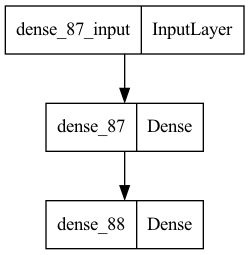

In [66]:
layer3_mlp = Sequential()
layer3_mlp.add(Dense(256, activation='relu', input_dim=(32*32*1)))
layer3_mlp.add(Dense(43, activation='softmax'))

plot_model(layer3_mlp, to_file='3lmlp.png')


### 2.1.2. Vergleich mehrerer Aktivierungsfunktionen

### 2.1.3. Vergleich mehrerer Optimizer

### 2.1.4 Variation von Batchsize und Anzahl der Epochs

In [16]:
# Create function to compile and fit a model with different batch sizes and plot the results
def fitAndPlotBat(x_train, y_train, x_test, y_test, batch_size):
    # define model
    model = Sequential()
    model.add(Dense(784, input_dim=(32*32*1), activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(43, activation='softmax'))

    # compile
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

    # fit model
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=50,
        batch_size=batch_size,
        verbose=1,
        validation_data=(x_test, y_test)
    )

    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='test_acc')
    plt.title('batch= ' + str(batch_size), pad=-40 )

(86989, 1, 32, 32)
Epoch 1/30
1360/1360 [==============================] - 27s 20ms/step - loss: 1.1547 - accuracy: 0.7224 - val_loss: 0.7531 - val_accuracy: 0.8086
Epoch 2/30
1360/1360 [==============================] - 27s 20ms/step - loss: 0.4481 - accuracy: 0.8933 - val_loss: 0.7600 - val_accuracy: 0.8013
Epoch 3/30
1360/1360 [==============================] - 27s 20ms/step - loss: 0.2998 - accuracy: 0.9246 - val_loss: 0.7651 - val_accuracy: 0.8160
Epoch 4/30
1360/1360 [==============================] - 27s 20ms/step - loss: 0.2255 - accuracy: 0.9399 - val_loss: 0.6190 - val_accuracy: 0.8640
Epoch 5/30
1360/1360 [==============================] - 26s 19ms/step - loss: 0.1804 - accuracy: 0.9516 - val_loss: 0.7003 - val_accuracy: 0.8451
Epoch 6/30
1360/1360 [==============================] - 25s 19ms/step - loss: 0.1533 - accuracy: 0.9579 - val_loss: 0.7953 - val_accuracy: 0.8507
Epoch 7/30
1360/1360 [==============================] - 25s 18ms/step - loss: 0.1278 - accuracy: 0.9639 -

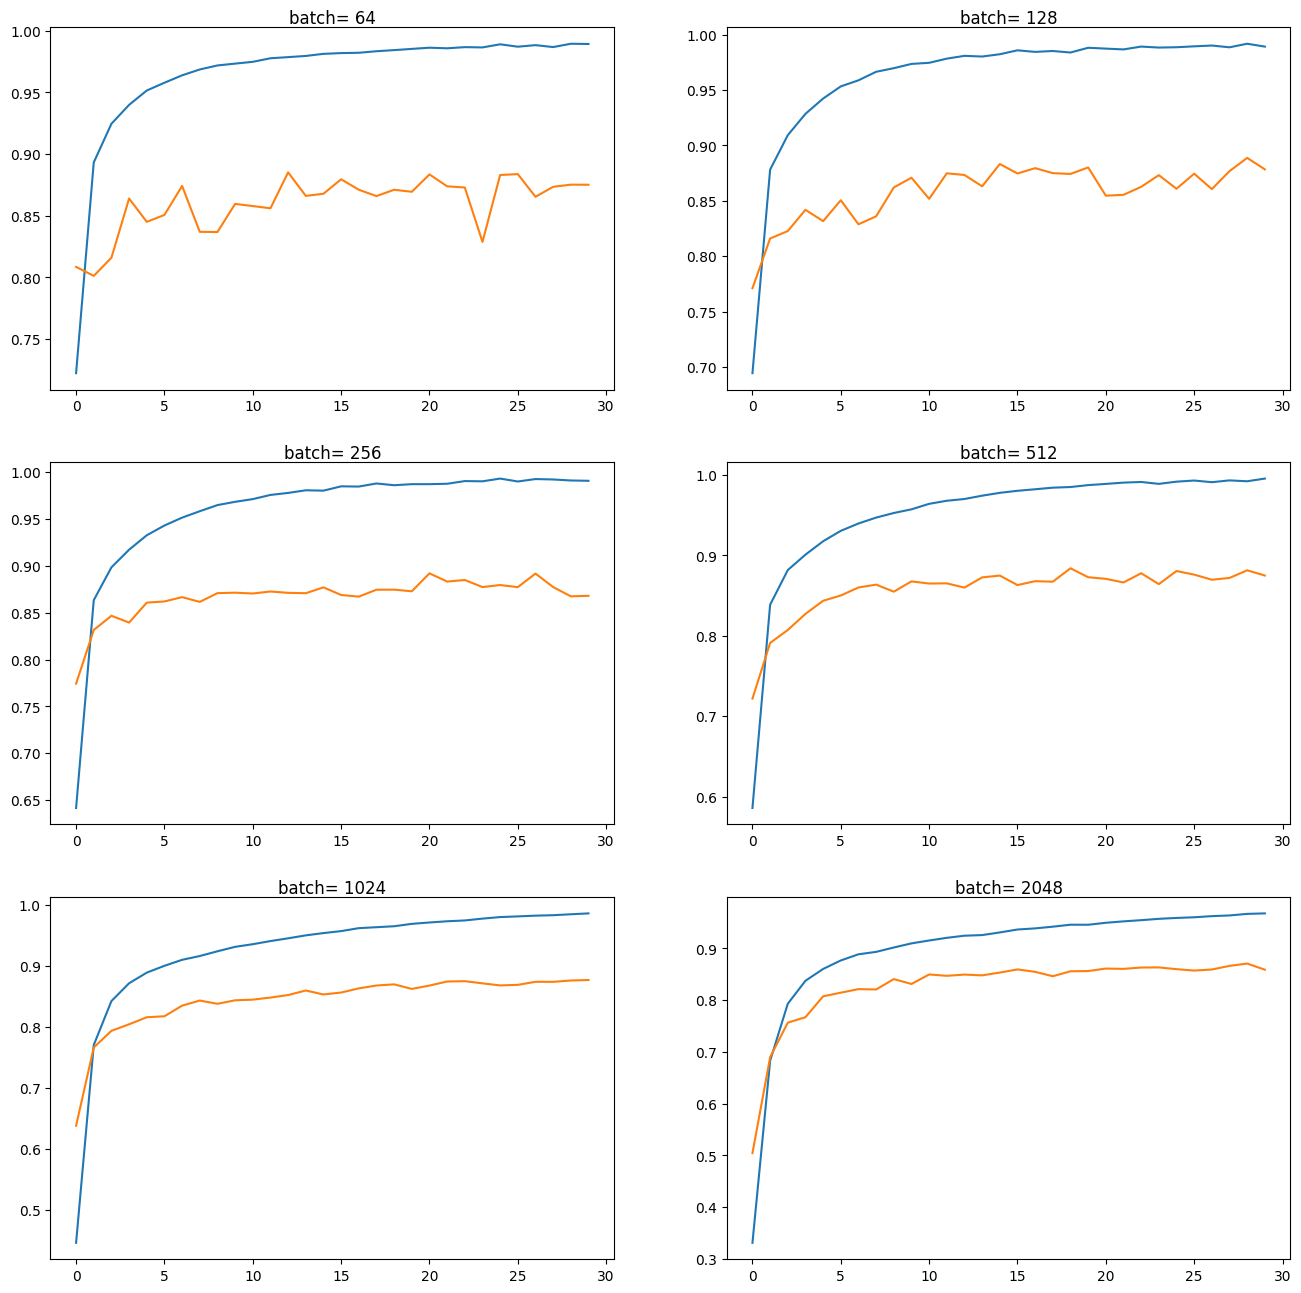

In [15]:
# Try different batch sizes
batch_sizes = [64, 128, 256, 512, 1024, 2048]
plt.figure(figsize=(16, 16))

print(data['x_train'].shape)

x_train1 = data['x_train'].reshape(data['x_train'].shape[0], 1*32*32).astype('float32')
x_test1 = data['x_test'].reshape(data['x_test'].shape[0], 1*32*32).astype('float32')
x_valid1 = data['x_validation'].reshape(data['x_validation'].shape[0], 1*32*32).astype('float32')


for i in range(len(batch_sizes)):
    #determine plot no
    plot_no = 320 + (i+1)
    plt.subplot(plot_no)

    #use function from above to fit and plot
    fitAndPlotBat(x_train=x_train1, 
        y_train=data['y_train'],
        x_test=x_test1,
        y_test=y_testing,
        batch_size=batch_sizes[i]
    )

plt.show()

(86989, 1, 32, 32)
Epoch 1/50
1360/1360 [==============================] - 23s 17ms/step - loss: 1.2235 - accuracy: 0.7055 - val_loss: 0.8450 - val_accuracy: 0.7835
Epoch 2/50
1360/1360 [==============================] - 23s 17ms/step - loss: 0.5005 - accuracy: 0.8837 - val_loss: 0.6922 - val_accuracy: 0.8284
Epoch 3/50
1360/1360 [==============================] - 22s 16ms/step - loss: 0.3399 - accuracy: 0.9173 - val_loss: 0.6467 - val_accuracy: 0.8519
Epoch 4/50
1360/1360 [==============================] - 22s 16ms/step - loss: 0.2537 - accuracy: 0.9359 - val_loss: 0.6953 - val_accuracy: 0.8447
Epoch 5/50
1360/1360 [==============================] - 21s 16ms/step - loss: 0.2073 - accuracy: 0.9455 - val_loss: 0.6475 - val_accuracy: 0.8708
Epoch 6/50
1360/1360 [==============================] - 21s 16ms/step - loss: 0.1674 - accuracy: 0.9549 - val_loss: 0.6605 - val_accuracy: 0.8734
Epoch 7/50
1360/1360 [==============================] - 22s 16ms/step - loss: 0.1420 - accuracy: 0.9612 -

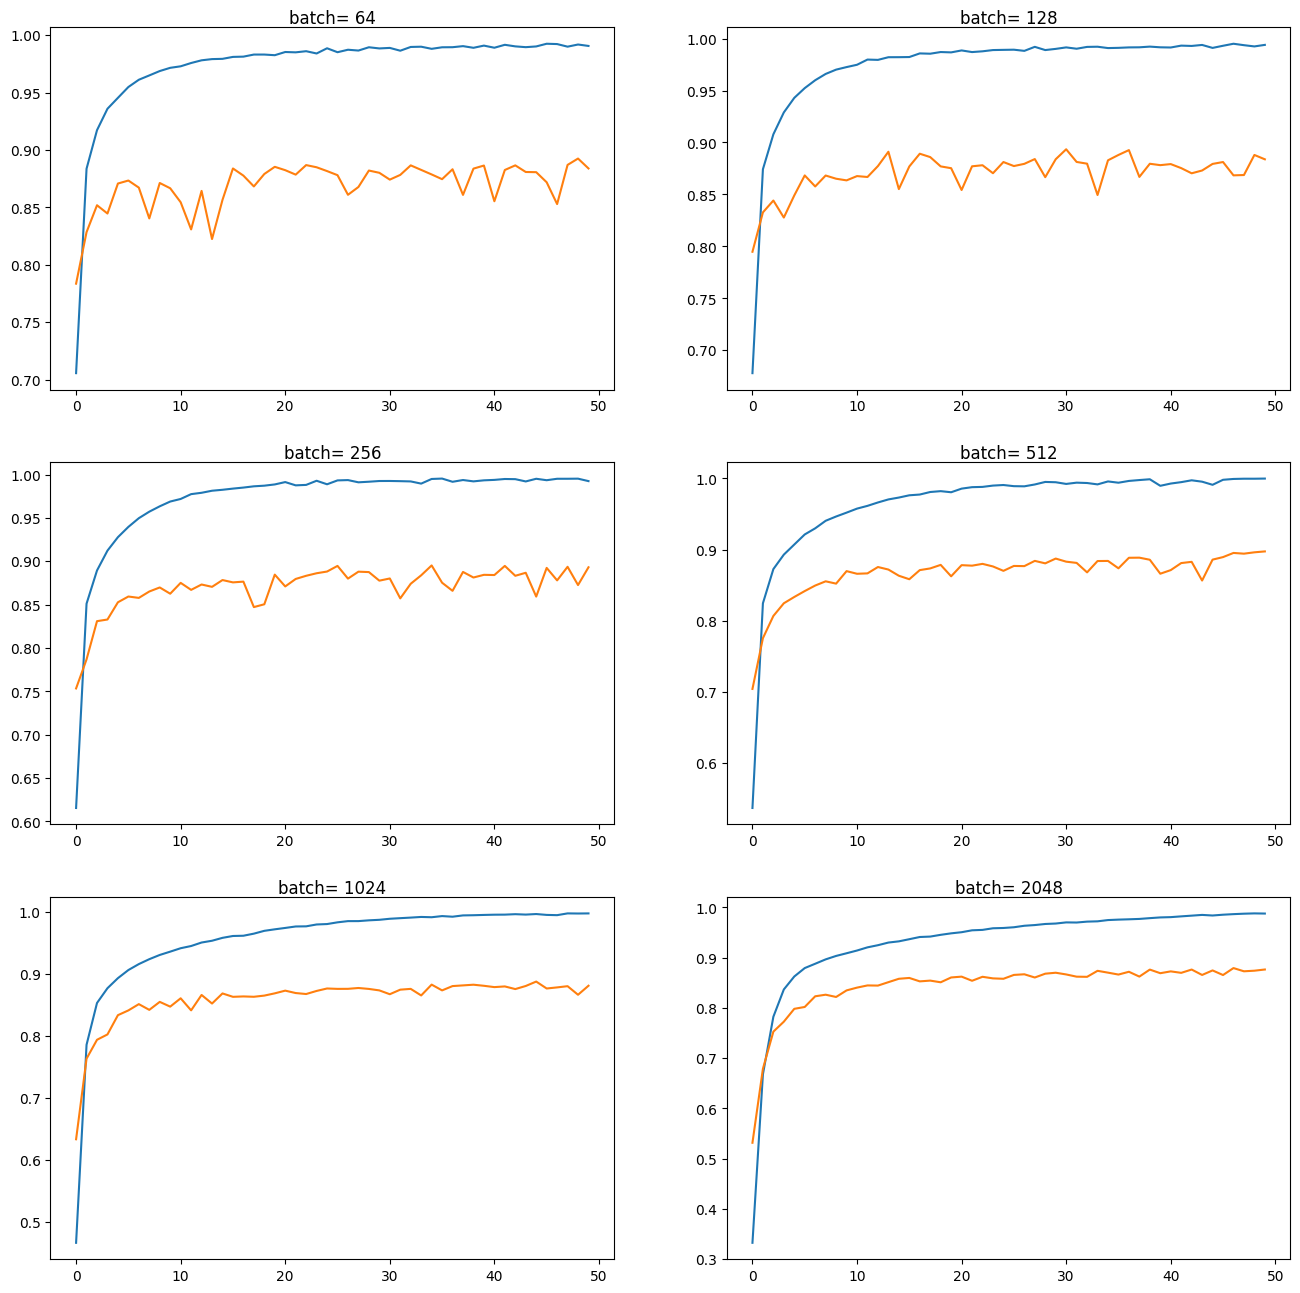

In [17]:
# Try different batch sizes
batch_sizes = [64, 128, 256, 512, 1024, 2048]
plt.figure(figsize=(16, 16))

print(data['x_train'].shape)

x_train1 = data['x_train'].reshape(data['x_train'].shape[0], 1*32*32).astype('float32')
x_test1 = data['x_test'].reshape(data['x_test'].shape[0], 1*32*32).astype('float32')
x_valid1 = data['x_validation'].reshape(data['x_validation'].shape[0], 1*32*32).astype('float32')


for i in range(len(batch_sizes)):
    #determine plot no
    plot_no = 320 + (i+1)
    plt.subplot(plot_no)

    #use function from above to fit and plot
    fitAndPlotBat(x_train=x_train1, 
        y_train=data['y_train'],
        x_test=x_test1,
        y_test=y_testing,
        batch_size=batch_sizes[i]
    )

plt.show()

## 2.2. Tiefes MLP (DNN)

### 2.2.1. Vergleich verschiedener Dropout-Stärken

### 2.2.2. Vergleich mehrerer Aktivierungsfunktionen

(ReLU, Leaky ReLU, Sigmoid)

### 2.2.3. Vergleich mehrerer Optimizer

### 2.2.4. Variation von Batchsize und Anzahl Epochs

## 2.3. Convolutional Neural Netowrks

### 2.3.1. Vergleich und Variation verschiedener Convolution-Layer und ihrer Metaparameter 

Filtersitze etc.

In [ ]:
#First try
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


hist = model.fit(x_train_gray, data_gray['y_train'], 
        epochs=1,
        batch_size=2048,
        verbose=1,
        validation_data=(x_test_gray, y_test_gray),  
)


y_pred = model.predict(x_test_gray)



### 2.3.2. Vergleich verschiedener Dropout-Stärken


### 2.3.3. Vergleich verschiedener Aktivierungsfunktionen

### 2.3.4. Vergleich mehrerer Optimizer

### 2.3.5. Variation von Batchsize und Anzahl Epochs

## 2.4. Convolutional Neural Networks mit Autoencoder

# 3. Anwendung der Ergebnisse auf die Klassifikation von RGB-Farbbildern